# Crosscorrelation functions in a 2D homogeneous acoustic medium with a point scatterer

This script demonstrate the cross-correlation functions at two receivers from ambient noise sources in a 2D homogeneous acoustic medium with a point scatterer. It also applies to single-frequency surface waves on the Earth's surface.

Author: Yunyue Elita Li, elitali@purdue.edu

Date: Nov 20, 2024

Key parameters to play with:
1. Number of random sources
2. Range of source angles
3. Source signature:
  - Impulsive source with Ricker wavelet
  - Random source (long duration) with flat spectrum
  - Random source (long duration) with Ricker spectrum
4. Location and scattering coefficient of the scatterer

Key observations:
1. When the noise sources are impulsive
  - Direct waves are well reconstructed in the stacked XCF
  - Scattered waves are reconstructed at different stationary phase angles

2. When the noise sources are continuous (long duration)
  - Direct waves are still well constructed in the stacked XCF
  - Source crosstalks may overwhelm the scattered waves in the later arrivals

In [1]:
# Import all necessary librarys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.signal import convolve, correlate

In [2]:
# prompt: mount google drive and add a subfolder to the Python path

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/EAPS 591 Fall 2024/Modules')

Mounted at /content/drive


In [3]:
from corrplot import *

# number of sources
nangles = 1000

# random angles of the plane waves
angles = np.random.uniform(0, 2*np.pi, nangles)
# sort the angles from low to high
angles = np.sort(angles)

# random times of the plane waves for Rayleigh wave sources
times = np.random.randn(nangles)

# define the locations of two receivers [x,y] in meters
receiver1 = np.array([200, 0])
receiver2 = np.array([600, 0])

# define the scatter location
scatter = np.array([200, 400])

# set the velocity of the medium m/s
vp = 800
vs = 400

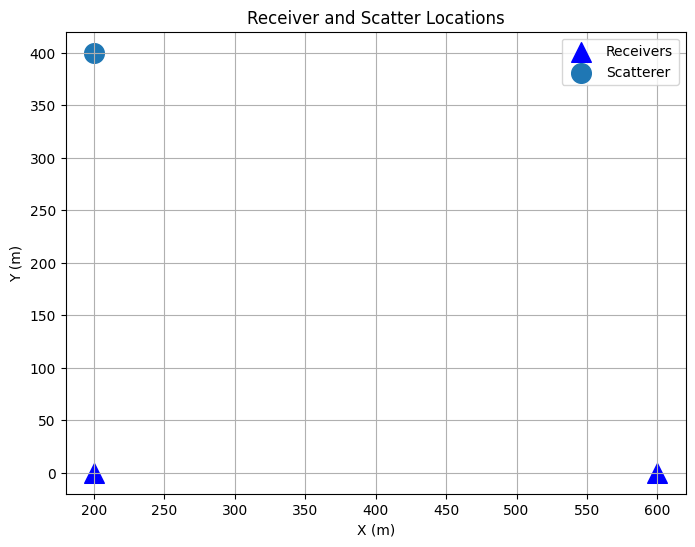

In [4]:
# prompt: plot the receiver locations and the scatter location

# Plot the receiver locations and the scatter location
plt.figure(figsize=(8, 6))
plt.scatter(receiver1[0], receiver1[1], marker='^', color='blue', s=200, label='Receivers')
plt.scatter(receiver2[0], receiver2[1], marker='^', color='blue', s=200)
plt.scatter(scatter[0], scatter[1], marker='o', s=200, label='Scatterer')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Receiver and Scatter Locations')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# calculate the arrival time at two receivers
p_drct_r1 = times + receiver1[0]*np.sin(angles)/vp + receiver1[1]*np.cos(angles)/vp
p_drct_r2 = times + receiver2[0]*np.sin(angles)/vp + receiver2[1]*np.cos(angles)/vp

# calculate the excitation time of the scattered waves
p_sct_times = times + scatter[0]*np.sin(angles)/vp + scatter[1]*np.cos(angles)/vp

# calculate the arrival times of the scatter waves at the two receivers
dist_s_r1 = np.sqrt((receiver1[0] - scatter[0])**2 + (receiver1[1] - scatter[1])**2)
dist_s_r2 = np.sqrt((receiver2[0] - scatter[0])**2 + (receiver2[1] - scatter[1])**2)
p_sct_r1 = p_sct_times + dist_s_r1/vp
p_sct_r2 = p_sct_times + dist_s_r2/vp

max_arrival_time_station1 = max(np.abs(p_sct_r1))
max_arrival_time_station2 = max(np.abs(p_sct_r2))

max_time = max(max_arrival_time_station1,max_arrival_time_station2)*1.02;

# define the passive acquisition
dt = 1e-3
taxis = np.arange(-max_time,max_time,dt)

record1 = np.zeros([len(taxis),len(angles)])
record2 = np.zeros([len(taxis),len(angles)])

In [6]:
# prompt: for each angle, find place 1 at the arrival times for each station
Aps = -0.3

for angle_index, (td1,ts1,td2,ts2) in enumerate(zip(p_drct_r1, p_sct_r1, p_drct_r2, p_sct_r2)):
  td_index_station1 = int((td1-taxis[0]) / dt)
  td_index_station2 = int((td2-taxis[0]) / dt)
  ts_index_station1 = int((ts1-taxis[0]) / dt)
  ts_index_station2 = int((ts2-taxis[0]) / dt)

  record1[td_index_station1, angle_index] = 1
  record1[ts_index_station1, angle_index] = Aps
  record2[td_index_station2, angle_index] = 1
  record2[ts_index_station2, angle_index] = Aps


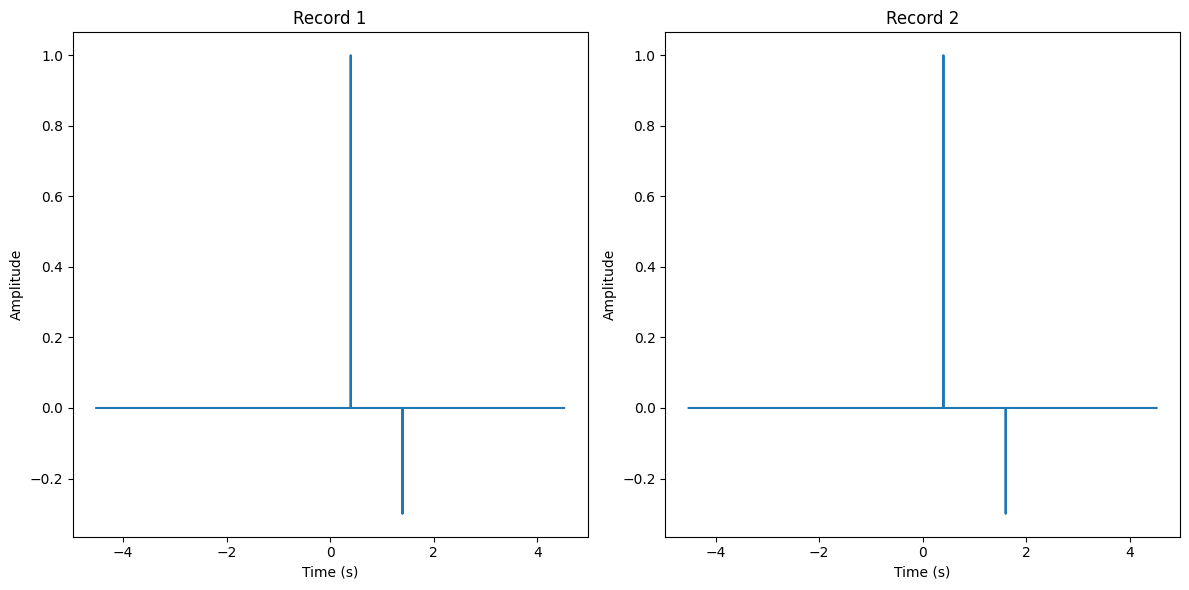

In [7]:
# plot the records plotN means number of angles to skip
plot_records(record1, record2, taxis, plotN=2900)

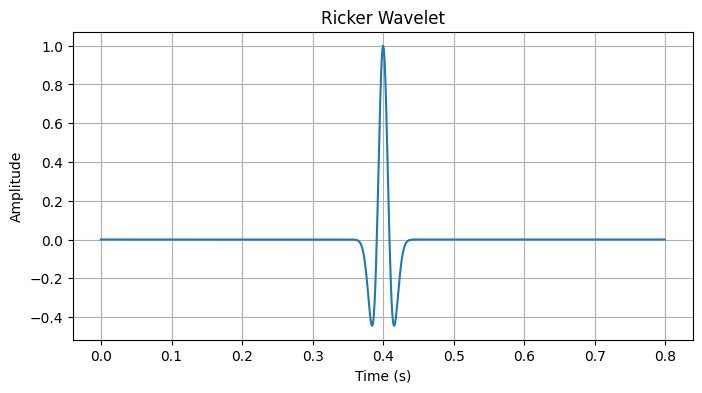

In [8]:
# Generate a ricker wavelet:
central_frequency = 25  # Hz
sampling_interval = dt
wavelet_length = 0.8  # seconds

ricker = ricker_wavelet(central_frequency, sampling_interval, wavelet_length)

# Plot the Ricker wavelet
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, len(ricker)) * sampling_interval, ricker)
plt.title('Ricker Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

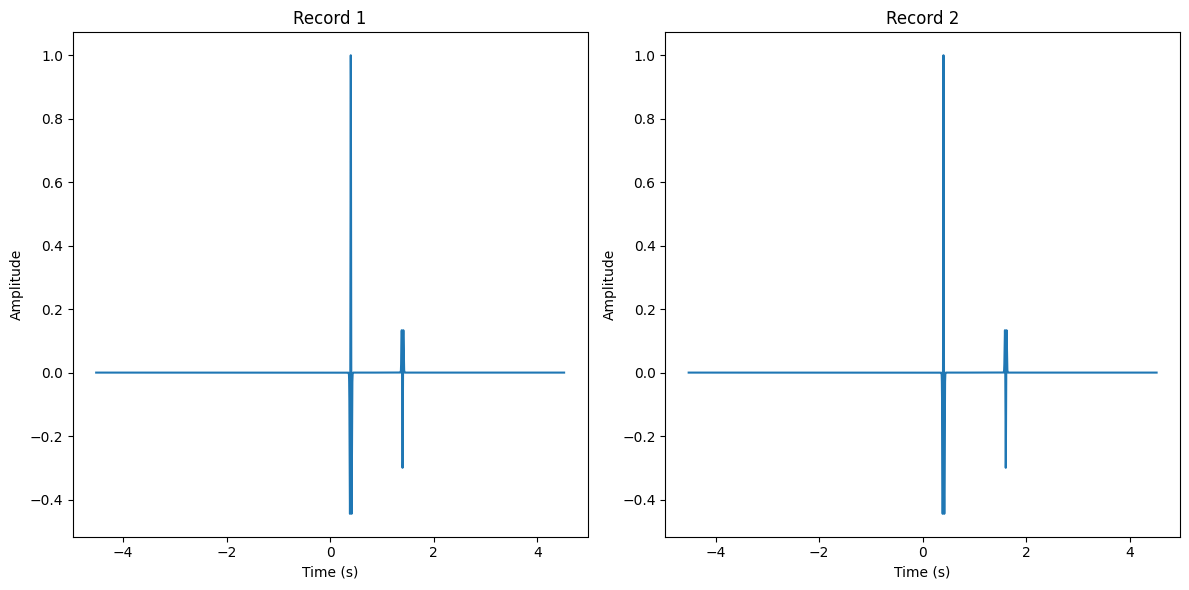

In [9]:
# Convolve record1 and record2 with the Ricker wavelet
convolved_record1 = np.zeros_like(record1)
convolved_record2 = np.zeros_like(record2)

for i in range(record1.shape[1]):
    convolved_record1[:, i] = convolve(record1[:, i], ricker, mode='same')
    convolved_record2[:, i] = convolve(record2[:, i], ricker, mode='same')

plot_records(convolved_record1, convolved_record2, taxis, plotN=2900)

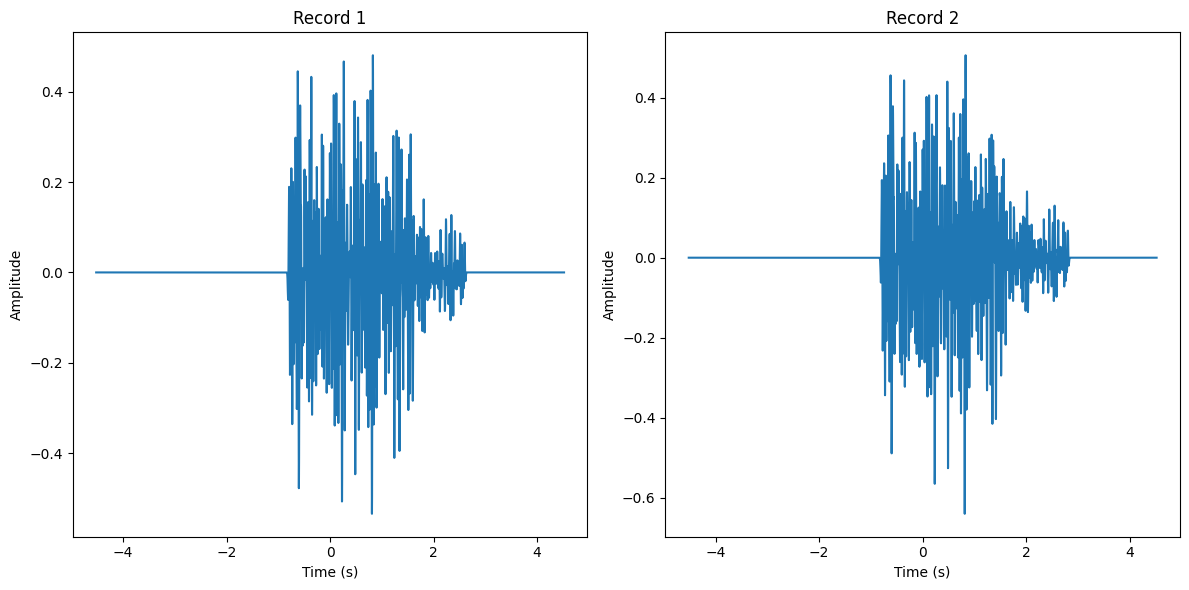

In [10]:
# Convolve convolved_record1 and convolved_record2 with random numbers
convolved_record1_random = np.zeros_like(convolved_record1)
convolved_record2_random = np.zeros_like(convolved_record2)

for i in range(convolved_record1.shape[1]):
    random_noise = np.random.randn(3*len(ricker))  # Generate random noise
    convolved_record1_random[:, i] = convolve(convolved_record1[:, i], random_noise, mode='same')
    convolved_record2_random[:, i] = convolve(convolved_record2[:, i], random_noise, mode='same')

# Normalize the correlated records
convolved_record1_random /= np.max(np.abs(convolved_record1_random))
convolved_record2_random /= np.max(np.abs(convolved_record2_random))

plot_records(convolved_record1_random, convolved_record2_random, taxis, plotN=2900)

In [11]:
# prompt: for each angle, cross-correlate the convolved record1 and record2,
epsilon = 1e-6
# Calculate cross-correlation for each angle
cross_correlations = []
for i in range(convolved_record1.shape[1]):
  correlation = correlate(convolved_record1[:, i], convolved_record2[:, i], mode='full')
  correlation /= np.max(np.abs(correlation)+epsilon)
  cross_correlations.append(correlation)

# Convert the list of cross-correlations to a NumPy array
cross_correlations_array = np.transpose(np.array(cross_correlations))
# Calculate the average cross-correlation across all angles
average_cross_correlation = np.mean(cross_correlations_array, axis=1)



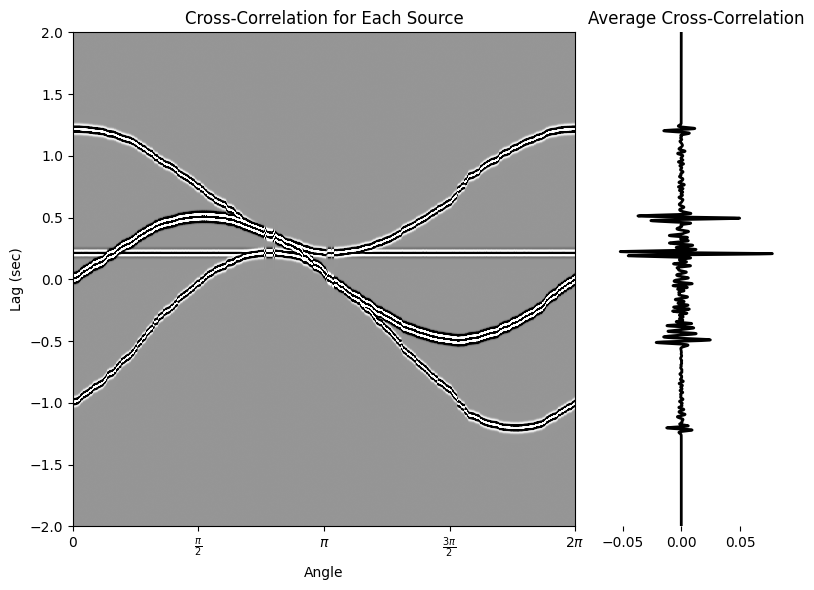

In [12]:
# Plot the cross-correlations
plot_cross_correlations(cross_correlations_array, angles, dt, maxlag=2, clippc=0.5, savefig=False)

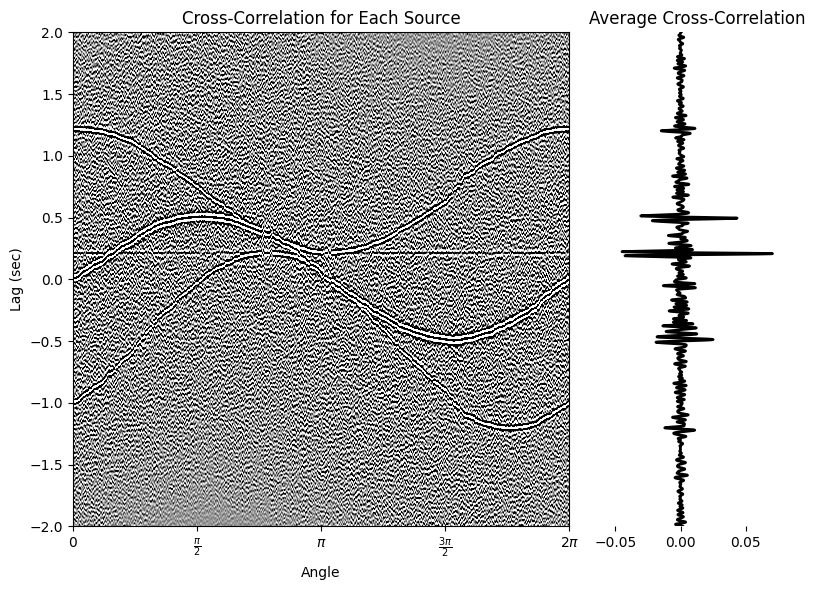

In [13]:
# prompt: cross-correlate the convolved_record1_random and convolved_record2_random

# Calculate cross-correlation for each angle for the randomly convolved records
cross_correlations_random = []
for i in range(convolved_record1_random.shape[1]):
    correlation_random = correlate(convolved_record1_random[:, i], convolved_record2_random[:, i], mode='full')
    correlation_random /= np.max(np.abs(correlation_random)+epsilon)
    cross_correlations_random.append(correlation_random)


# Convert the list of cross-correlations to a NumPy array
cross_correlations_random_array = np.transpose(np.array(cross_correlations_random))

# Calculate the average cross-correlation across all angles for the randomly convolved records
average_cross_correlation_random = np.mean(cross_correlations_random_array, axis=1)

# plot the cross-correlations
plot_cross_correlations(cross_correlations_random_array, angles, dt, maxlag=2, clippc=0.5, savefig=False)

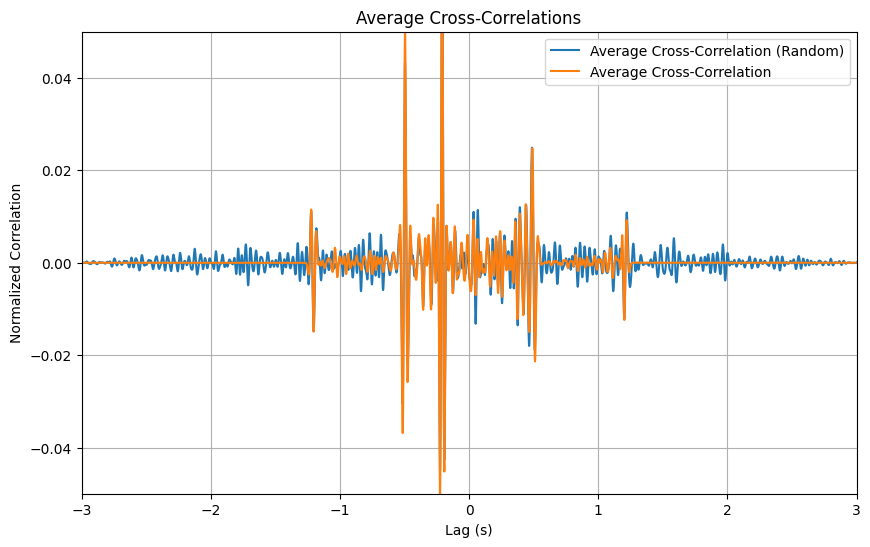

In [14]:
# prompt: plot the average cross correlation and average cross correlation random together

# Assuming 'average_cross_correlation' and 'average_cross_correlation_random' are defined as in the provided code

lags = np.arange(-len(average_cross_correlation)//2, len(average_cross_correlation)//2) * dt

plt.figure(figsize=(10, 6))
plt.plot(lags, average_cross_correlation_random, label='Average Cross-Correlation (Random)')
plt.plot(lags, average_cross_correlation, label='Average Cross-Correlation')
plt.xlim(-3,3)
plt.ylim(-0.05,0.05)
plt.xlabel('Lag (s)')
plt.ylabel('Normalized Correlation')
plt.title('Average Cross-Correlations')
plt.legend()
plt.grid(True)
plt.show()

# Autocorrelation

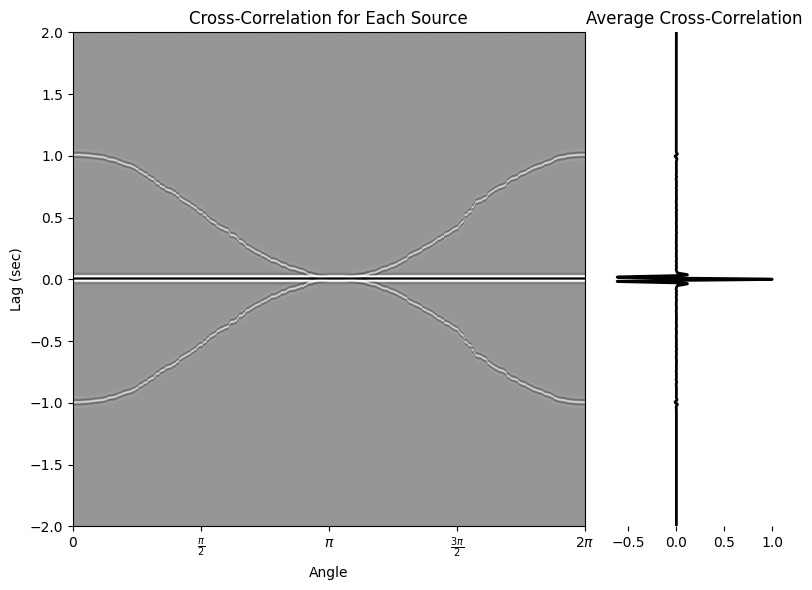

In [15]:
# prompt: for each angle, cross-correlate the convolved record1 and record2,
epsilon = 1e-6
# Calculate cross-correlation for each angle
cross_correlations = []
for i in range(convolved_record1.shape[1]):
  correlation = correlate(convolved_record1[:, i], convolved_record1[:, i], mode='full')
  correlation /= np.max(np.abs(correlation)+epsilon)
  cross_correlations.append(correlation)

# Convert the list of cross-correlations to a NumPy array
auto_correlations_array = np.transpose(np.array(cross_correlations))
# Calculate the average cross-correlation across all angles
average_auto_correlation = np.mean(auto_correlations_array, axis=1)

plot_cross_correlations(auto_correlations_array, angles, dt, maxlag=2, clippc=0.5, savefig=False)

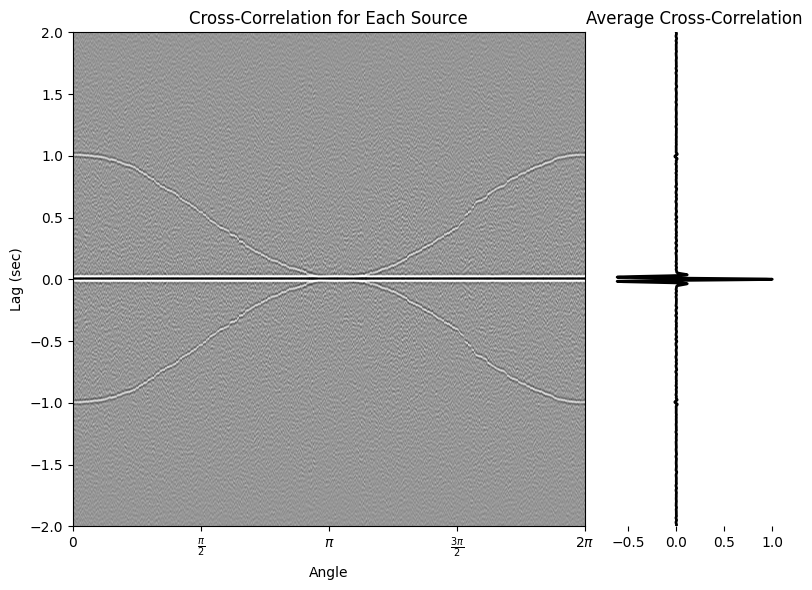

In [16]:
# prompt: for each angle, cross-correlate the convolved record1 and record2,
epsilon = 1e-6
# Calculate cross-correlation for each angle
cross_correlations = []
for i in range(convolved_record1.shape[1]):
  correlation = correlate(convolved_record1_random[:, i], convolved_record1_random[:, i], mode='full')
  correlation /= np.max(np.abs(correlation)+epsilon)
  cross_correlations.append(correlation)

# Convert the list of cross-correlations to a NumPy array
ac_randsrc_array = np.transpose(np.array(cross_correlations))
# Calculate the average cross-correlation across all angles
avg_ac_randsrc = np.mean(ac_randsrc_array, axis=1)

plot_cross_correlations(ac_randsrc_array, angles, dt, maxlag=2, clippc=0.5, savefig=False)

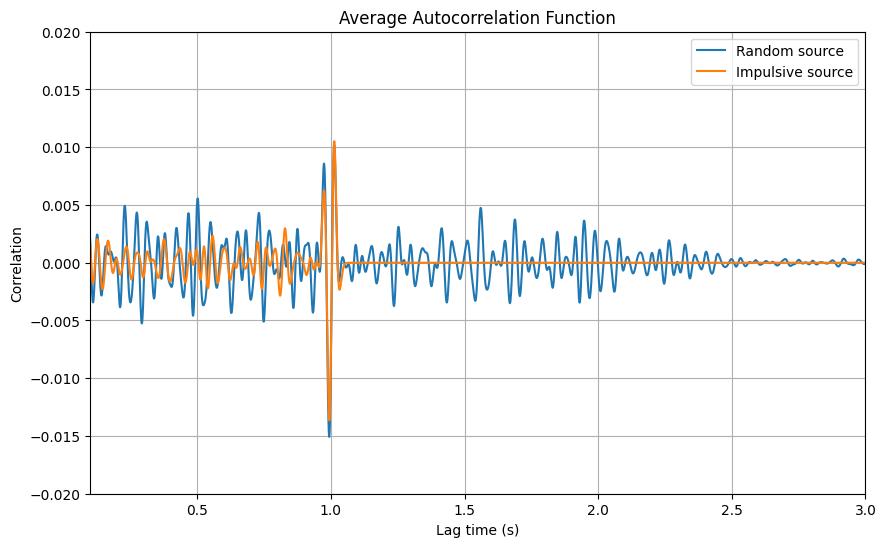

In [17]:
# prompt: plot average_auto_correlation and  avg_ac_randsrc in the same figure

import matplotlib.pyplot as plt

# get the time lag axis
lag_axis = np.arange(-len(average_cross_correlation) // 2, len(average_cross_correlation) // 2) * dt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(lag_axis, avg_ac_randsrc, label='Random source')
plt.plot(lag_axis, average_auto_correlation, label='Impulsive source')

plt.xlim(0.1,3)
plt.ylim(-0.02,0.02)
# Customize the plot
plt.xlabel("Lag time (s)")  # Replace with appropriate label if available
plt.ylabel("Correlation")  # Replace with appropriate label if available
plt.title("Average Autocorrelation Function")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()